# Single-Shell Three-Tissue Constrained Spherical Deconvolution

Multi-Tissue CSD (MT-CSD), or what *Jeurissen et al. (2014)* refers to as Multi-Shell Multi-Tissue CSD (MSMT-CSD), is in extension of regular CSD algorithm. In MT-CSD, Aside from the standard white matter convolution kernel, also a CSF and grey matter kernel are estimated from the data, and fitted simultaneously fitted for better FOD estimation.

$$
\begin{equation}
 E_{\textrm{MT-CSD}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{CSF}}+ \underbrace{f_{\textrm{GM}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{Grey Matter}} + \underbrace{f_r\left[\overbrace{\operatorname{FOD}(\operatorname{SH}|l_{\textrm{max}})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{E_{\textrm{WM}}(\cdot)}^{\textrm{Anisotropic Response}}\right]}_{\textrm{White Matter}}
\end{equation}
$$

Normally, since we are fitting 3 different compartments, we would need multi-shell data to estimate meaningful volume fractions. However, *Dhollander et al. (2016)* proposed an iterative bi-convex optimization strategy that allows to estimate the three-tissue CSD algorithm (WM + GM + CSF) from single-shell data (1 shell + b0), that at least looks similar to the multi-shell result.

The algorithm is fairly simple and can be very simply implemented using Dmipy. It consists of 2 steps:  
- 1: Fix the WM fraction to 0. and estimate (GM + CSF), this results in an overestimation of CSF.
- 2: Estimate WM + GM while fixing CSF to the result of the previous step.

In the next iteration the WM fraction is fixed to the result of the 2nd step of the previous iteration. Specifically, *Dhollander et al.* say 4 iterations of this algorithm is enough to get multi-shell results out of single-shell data. In this example, we will implement this algorithm, study a bit why this is so and if it actually works.

## Data Preparation for single-shell data from multi-shell HCP data

First, we prepare some single-shell data from the multi-shell HCP slice that we use for examples.

In [4]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [5]:
scheme_hcp.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  
2           |90        |2000            |79                       |10.6       |43.1      |N/A  
3           |90        |3000            |97                       |10.6       |43.1      |N/A  


In [6]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
wm, gm, csf, selection_map = three_tissue_response_dhollander16(
    scheme_hcp, data_hcp, wm_algorithm='tournier07',
    wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
tissue_response = [wm, gm, csf]

In [7]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
# we also fit the MT-CSD model to the multi-shell data as comparison
mtcsd_mod_3shell = (
    MultiCompartmentSphericalHarmonicsModel(tissue_response))
mtcsd_fit_3shell = mtcsd_mod_3shell.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, fit_S0_response=True)

Setup CVXPY FOD optimizer in 0.00937604904175 seconds
Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 224.653085947 seconds.
Average of 0.0274603454281 seconds per voxel.


In [8]:
data_hcp_csf_filtered = mtcsd_fit_3shell.return_filtered_signal(['partial_volume_2'])

In [9]:
from dmipy.core.acquisition_scheme import gtab_mipy2dipy
from dipy.reconst.mapmri import MapmriModel
gtab = gtab_mipy2dipy(scheme_hcp)
mapmod = MapmriModel(gtab)

In [10]:
mapfit_raw = mapmod.fit(data_hcp, mask=data_hcp[..., 0]>0)
mapfit_filtered = mapmod.fit(data_hcp_csf_filtered, mask=data_hcp_csf_filtered[..., 0]>0)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'QIV')

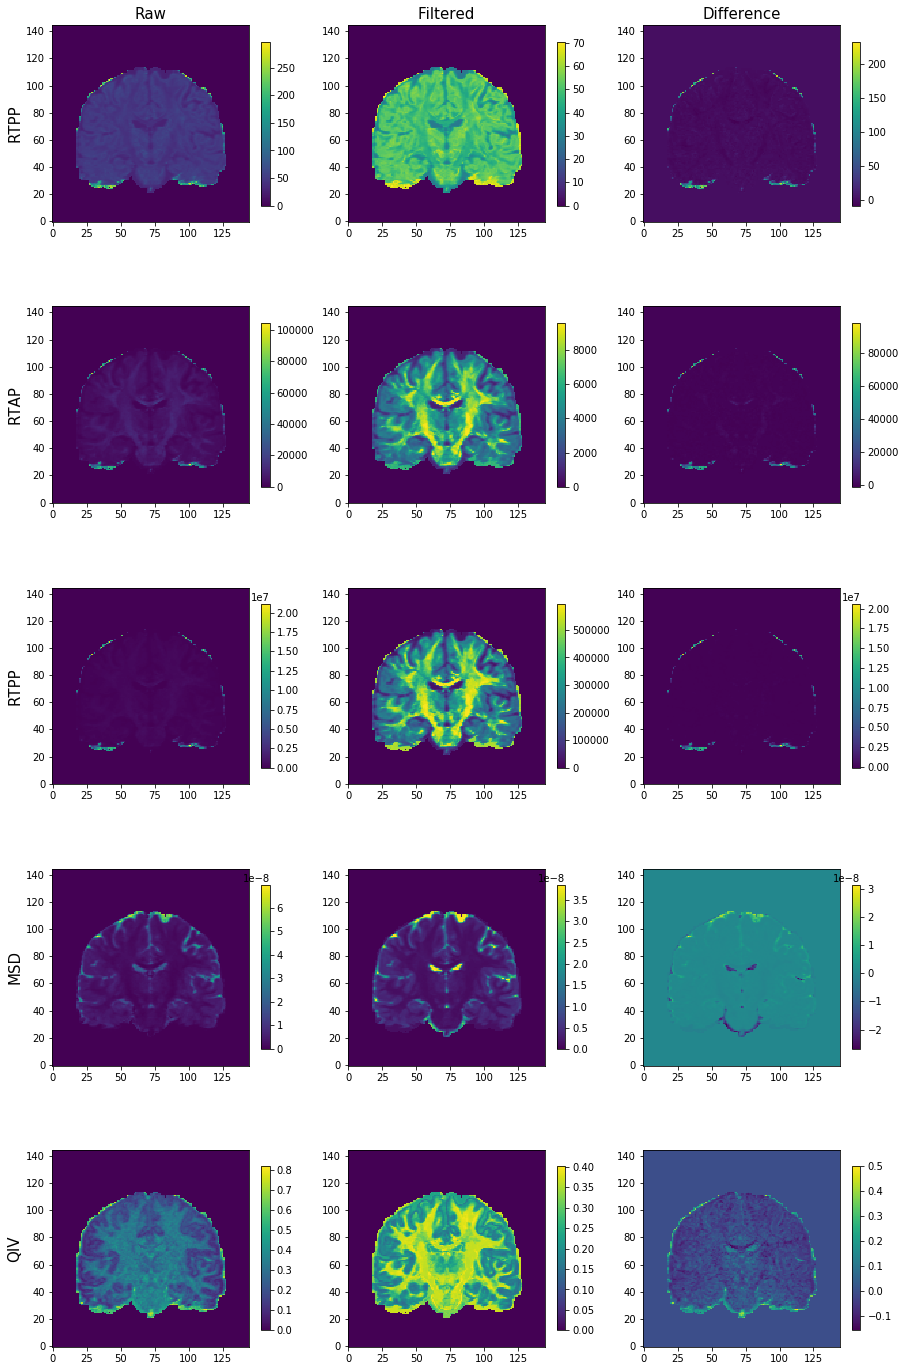

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=[15, 25])
axs = axs.ravel()

im = axs[0].imshow(mapfit_raw.rtpp().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[0], shrink=0.7)
im = axs[1].imshow(mapfit_filtered.rtpp().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[1], shrink=0.7)
im = axs[2].imshow((mapfit_raw.rtpp().squeeze() - mapfit_filtered.rtpp().squeeze()).T, origin=True)
fig.colorbar(im, ax=axs[2], shrink=0.7)
im = axs[3].imshow(mapfit_raw.rtap().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[3], shrink=0.7)
im = axs[4].imshow(mapfit_filtered.rtap().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[4], shrink=0.7)
im = axs[5].imshow((mapfit_raw.rtap().squeeze() - mapfit_filtered.rtap().squeeze()).T, origin=True)
fig.colorbar(im, ax=axs[5], shrink=0.7)
im = axs[6].imshow(mapfit_raw.rtop().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[6], shrink=0.7)
im = axs[7].imshow(mapfit_filtered.rtop().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[7], shrink=0.7)
im = axs[8].imshow((mapfit_raw.rtop().squeeze() - mapfit_filtered.rtop().squeeze()).T, origin=True)
fig.colorbar(im, ax=axs[8], shrink=0.7)
im = axs[9].imshow(mapfit_raw.qiv().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[9], shrink=0.7)
im = axs[10].imshow(mapfit_filtered.qiv().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[10], shrink=0.7)
im = axs[11].imshow((mapfit_raw.qiv().squeeze() - mapfit_filtered.qiv().squeeze()).T, origin=True)
fig.colorbar(im, ax=axs[11], shrink=0.7)
im = axs[12].imshow(mapfit_raw.ng().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[12], shrink=0.7)
im = axs[13].imshow(mapfit_filtered.ng().squeeze().T, origin=True)
fig.colorbar(im, ax=axs[13], shrink=0.7)
im = axs[14].imshow((mapfit_raw.ng().squeeze() - mapfit_filtered.ng().squeeze()).T, origin=True)
fig.colorbar(im, ax=axs[14], shrink=0.7)
axs[0].set_title('Raw', fontsize=15)
axs[1].set_title('Filtered', fontsize=15)
axs[2].set_title('Difference', fontsize=15)
axs[0].set_ylabel('RTPP', fontsize=15)
axs[3].set_ylabel('RTAP', fontsize=15)
axs[6].set_ylabel('RTPP', fontsize=15)
axs[9].set_ylabel('MSD', fontsize=15)
axs[12].set_ylabel('QIV', fontsize=15)